# Circuit Parameters
This notebook uses the `impedance` package to fit equivalent circuit models to EIS data and retrieve the circuit parameters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist
from primed_data_processing.gamry_eis import EisSweep

In [2]:
# read data in from molicel P42A dataset
path = 'C:/Users/seanb/OneDrive/Documents/PRIMED/export/batdat/MTC/raws/B6T15V0_1_2_3_4_9_10_11_12_13_14_15_16/EIS/B6T10V0_Chan001_Cycle045_Step014.DTA'
eis_sweep = EisSweep('', 0.5, 14)
eis_sweep.read_DTA_file(path)

# get first quadrant data a.k.a ignore the values below the x-axis and behind the y-axis.
eis_sweep.make_first_quadrant_dict()

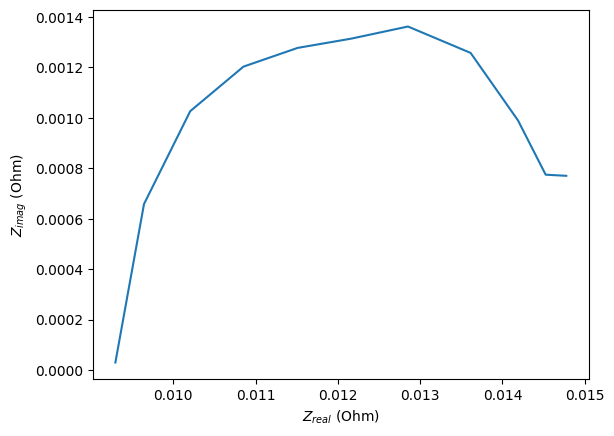

In [5]:
plt.plot(eis_sweep.first_dict['Zreal (ohm)'], np.array(eis_sweep.first_dict['Zimag (ohm)'])*-1)
plt.xlabel(r"$Z_{real}$ (Ohm)")
plt.ylabel(r"$Z_{imag}$ (Ohm)");

In [6]:
def get_initial_warbug(eis_sweep):
    """
    Returns an estimate for a reasonable estimate of the warbug element value.
    """
    slope = ( (eis_sweep.first_dict['Zimag (ohm)'][-1] - eis_sweep.first_dict['Zimag (ohm)'][-2])
             / (eis_sweep.first_dict['Zreal (ohm)'][-1] - eis_sweep.first_dict['Zreal (ohm)'][-2]) )
    intercept = 0.0133
    return np.abs(slope/intercept)

def make_Z(eis_sweep):
    """
    Returns the Zreal and Zimag values as a python complex number.
    """
    Z = []
    for idx, real in enumerate(eis_sweep.first_dict['Zreal (ohm)']):
        Z.append(complex(real, eis_sweep.first_dict['Zimag (ohm)'][idx]))
    return Z

In [7]:
# make circuit
init_R0 = eis_sweep.first_dict['Zreal (ohm)'][0]
init_R1 = eis_sweep.first_dict['Zreal (ohm)'][-2]
init_Wo1 = get_initial_warbug(eis_sweep)
init_c = 1/(2 * np.pi * eis_sweep.first_dict['Freq (Hz)'][3] * init_R1)

circuit = CustomCircuit(circuit='R_0-p(R_1-W_1,C_0)',
                        initial_guess=[None, init_R1, init_Wo1, init_c],
                        constants={'R_0': init_R0})
RCcircuit = CustomCircuit(circuit='R_0-p(R_1,C_1)-p(R_2,C_2)-p(R_3,C_3)',
                        initial_guess=[None, 1, 1, 1, 1, 1, 1],
                        constants={'R_0': init_R0})
# RCcircuit = CustomCircuit(circuit='R_0-p(R_1,C_1)-p(R_2,C_2)-p(R_3,C_3)-p(R_4,C_5)',
#                         initial_guess=[None, 1, 1, 1, 1, 1, 1, 1, 1],
#                         constants={'R_0': init_R0})
RCWcircuit = CustomCircuit(circuit='R_0-p(R_1,C_1)-p(R_2-W_1,C_2)',
                        initial_guess=[None, 1, 1, 1, 1, 1],
                        constants={'R_0': init_R0})

In [8]:
print(circuit)
print(RCcircuit)


Circuit string: R_0-p(R_1-W_1,C_0)
Fit: False

Constants:
    R_0 = 9.30e-03 [Ohm]

Initial guesses:
    R_1 = 1.45e-02 [Ohm]
    W_1 = 1.32e+00 [Ohm sec^-1/2]
    C_0 = 5.10e-02 [F]


Circuit string: R_0-p(R_1,C_1)-p(R_2,C_2)-p(R_3,C_3)
Fit: False

Constants:
    R_0 = 9.30e-03 [Ohm]

Initial guesses:
    R_1 = 1.00e+00 [Ohm]
    C_1 = 1.00e+00 [F]
    R_2 = 1.00e+00 [Ohm]
    C_2 = 1.00e+00 [F]
    R_3 = 1.00e+00 [Ohm]
    C_3 = 1.00e+00 [F]



In [11]:
circuit.fit(eis_sweep.first_dict['Freq (Hz)'], make_Z(eis_sweep))
RCcircuit.fit(eis_sweep.first_dict['Freq (Hz)'], make_Z(eis_sweep))
RCWcircuit.fit(eis_sweep.first_dict['Freq (Hz)'], make_Z(eis_sweep))
print(circuit)
print(RCcircuit)
print(RCWcircuit)


Circuit string: R_0-p(R_1-W_1,C_0)
Fit: True

Constants:
    R_0 = 9.30e-03 [Ohm]

Initial guesses:
    R_1 = 1.45e-02 [Ohm]
    W_1 = 1.32e+00 [Ohm sec^-1/2]
    C_0 = 5.10e-02 [F]

Fit parameters:
    R_1 = 3.85e-03  (+/- 2.23e-04) [Ohm]
    W_1 = 3.57e-03  (+/- 7.18e-04) [Ohm sec^-1/2]
    C_0 = 3.20e-01  (+/- 4.44e-02) [F]


Circuit string: R_0-p(R_1,C_1)-p(R_2,C_2)-p(R_3,C_3)
Fit: True

Constants:
    R_0 = 9.30e-03 [Ohm]

Initial guesses:
    R_1 = 1.00e+00 [Ohm]
    C_1 = 1.00e+00 [F]
    R_2 = 1.00e+00 [Ohm]
    C_2 = 1.00e+00 [F]
    R_3 = 1.00e+00 [Ohm]
    C_3 = 1.00e+00 [F]

Fit parameters:
    R_1 = 1.20e-03  (+/- 2.25e-04) [Ohm]
    C_1 = 1.12e+02  (+/- 3.74e+01) [F]
    R_2 = 2.53e-03  (+/- 1.64e-04) [Ohm]
    C_2 = 3.15e+00  (+/- 4.53e-01) [F]
    R_3 = 2.36e-03  (+/- 1.37e-04) [Ohm]
    C_3 = 2.20e-01  (+/- 1.65e-02) [F]


Circuit string: R_0-p(R_1,C_1)-p(R_2-W_1,C_2)
Fit: True

Constants:
    R_0 = 9.30e-03 [Ohm]

Initial guesses:
    R_1 = 1.00e+00 [Ohm]
    C_1 = 1

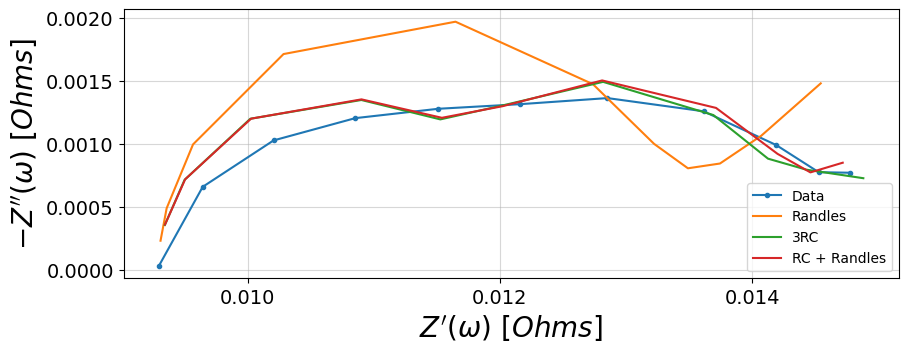

In [12]:
f_pred = np.linspace(0.1, 100, num=1000)
circuit_fit = circuit.predict(eis_sweep.first_dict['Freq (Hz)'])
RCcircuit_fit = RCcircuit.predict(eis_sweep.first_dict['Freq (Hz)'])
RCWcircuit_fit = RCWcircuit.predict(eis_sweep.first_dict['Freq (Hz)'])

fig, ax = plt.subplots(figsize=(10,10))
plot_nyquist(make_Z(eis_sweep), ax=ax)
plot_nyquist(circuit_fit, ax=ax, fmt='-')
plot_nyquist(RCcircuit_fit, ax=ax, fmt='-')
plot_nyquist(RCWcircuit_fit, ax=ax, fmt='-')
ax.legend(['Data', 'Randles', '3RC', 'RC + Randles'])

In [14]:
# display the circuit parameters so that they can be copied into 
# the simulation files
print(RCcircuit.parameters_)
print("Resistance: ", RCcircuit.parameters_[::2])
print("Capacitance: ", RCcircuit.parameters_[1::2])

[1.20406554e-03 1.11539560e+02 2.52689583e-03 3.15192951e+00
 2.35745438e-03 2.19522137e-01]
Resistance:  [0.00120407 0.0025269  0.00235745]
Capacitance:  [111.53955962   3.15192951   0.21952214]
